In [1]:
import seaborn as sns
import statsmodels.tsa.stattools as ts 
import statsmodels.api as sm
from numpy import log, polyfit, sqrt, std, subtract
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
import math

import pyfolio as pf
from scipy import stats

import ffn

from backtester import backtest as bt
from backtester import backtest_with_cost as btwc

%matplotlib inline

In [2]:
def find_ssd(df, pairs):
    
    ssd = {}
    for p in pairs:
        pair = p[0]+','+p[1]
        
        A = df[p[0]]
        B = df[p[1]]
        
        s = np.sum((A-B)**2)
        
        if s > 1.0:
            continue
            
        ssd[pair] = s
        
    return ssd


def find_tradeble_pairs(ssd):
    sorted_lst = sorted(ssd, key=ssd.get)
    amount = 4.0
    pair_lst = []
    if len(sorted_lst) < 1:
        return pair_lst
    elif amount < len(sorted_lst):       
        for n in range(amount):
            pair_lst.append(sorted_lst[n].split(","))
    else:
        for n in range(len(sorted_lst)):
            pair_lst.append(sorted_lst[n].split(","))

    return pair_lst

In [3]:
def create_pairs(tickers):
        result = []
        for p1 in range(len(tickers)):
                for p2 in range(p1+1,len(tickers)):
                        result.append([tickers[p1],tickers[p2]])
        return result
    
def get_closing(temp, name):
    temp.DATE = pd.to_datetime(temp['DATE'].str[:10], dayfirst=True)
    temp = temp.set_index(temp.DATE)
    
    temp.columns = ['Date', 'Symbol', 'Interval', 'Open', 'High', 'Low', name, 'Volume']
    temp = temp[name]
    return temp

def get_volume(temp, name):
    temp.DATE = pd.to_datetime(temp['DATE'].str[:10], dayfirst=True)
    temp = temp.set_index(temp.DATE)
    temp['OHLC4'] = (temp.OPEN + temp.HIGH + temp.LOW + temp.CLOSE) / 4 
    temp[name] = temp.VOLUME * temp.OHLC4
    
    temp = temp[name]
    return temp


def find_entry_exit(spread, n):
    mean = np.mean(spread)
    stdev = np.std(spread)
    upper = mean+(n*stdev)
    lower = mean-(n*stdev)
    
    return mean, upper, lower

def create_signal(df, pair, m, u, l):
    spread = df[pair[0]] - df[pair[1]]
    previous_spread = spread.shift(1)
    bt_df = pd.DataFrame()
    
    bt_df[pair[0]] = df[pair[0]]
    bt_df[pair[1]] = df[pair[1]]
    bt_df['shortsignal'] = ((spread < u) & (previous_spread > u))
    bt_df['longsignal'] = ((spread > l) & (previous_spread < l))
    bt_df['closelong'] = np.where(spread >= m, 1, 0)
    bt_df['closeshort'] = np.where(spread <= m, 1, 0)
    
    return bt_df


def trading(df_formation, df_trading, pairs, n):
    returns = pd.DataFrame()
    
    ssd = find_ssd(df_formation, pairs)
    selected = find_tradeble_pairs(ssd)
    
    for pair in selected:
        bt_name = pair[0]+pair[1]
        spread = df_formation[pair[0]] - df_formation[pair[1]]
        m, u, l = find_entry_exit(spread, n) 
        
        bt_df = create_signal(df_trading, pair, m, u, l)
        ret = bt(bt_df, pair[0], pair[1])
        
        returns[bt_name] = ret.returns
        
    returns['mean'] = returns.mean(axis=1)
    returns = returns.set_index(df_trading.index)
    return returns['mean']
    
    

def backtest(df, pairs, n):
    overall_ret = pd.DataFrame()
    
    start = pd.Timestamp('2000-01')
    mid = start + relativedelta(months=+12)
    end = start + relativedelta(months=+18)
    
    df_formation = (1 + df[start:mid].pct_change()).cumprod()
    df_trading = (1 + df[mid:end].pct_change()).cumprod()
    
    returns = trading(df_formation, df_trading, pairs, n)
    overall_ret = returns

    for period in range(1, 19*2):
        start = start + relativedelta(months=+6)
        mid = start + relativedelta(months=+12)
        end = start + relativedelta(months=+18)
        
        df_formation = (1 + df[start:mid].pct_change()).cumprod()
        df_trading = (1 + df[mid:end].pct_change()).cumprod()

        returns = trading(df_formation, df_trading, pairs, n)
        overall_ret = overall_ret.append(returns)
        
    return overall_ret

In [4]:
tickers = pd.read_excel('C:/Users/jango/Documents/BFH/BTHE/Sectors.xlsx', sheet_name=None)

hc_tickers = tickers['hc'].Ticker.tolist()
cg_tickers = tickers['cg'].Ticker.tolist()
fin_tickers = tickers['fin'].Ticker.tolist()
ind_tickers = tickers['ind'].Ticker.tolist()
all_tickers = tickers['all'].Ticker.tolist()

In [5]:
UBS = pd.read_csv('C:/Users/jango/code/research_env/BTHE/Datalink/csv/UBSG.csv', delimiter=";")
UBS.DATE = pd.to_datetime(UBS['DATE'].str[:10], dayfirst=True)
df = pd.DataFrame(UBS.CLOSE).set_index(UBS.DATE)
df.columns = ['UBS']
df = df.drop(columns=['UBS'])

In [6]:
pairs = create_pairs(all_tickers)

In [7]:
selected_pairs = [['LISN', 'LISP'], ['ROG', 'RO'], ['SCHN', 'SCHP'], ['UHR', 'UHRN']]
tickers = ['LISN', 'LISP', 'ROG', 'RO', 'SCHN', 'SCHP', 'UHR', 'UHRN']

In [8]:
for ticker in tickers:
    path = 'C:/Users/jango/code/research_env/BTHE/Datalink/csv/'+ticker+'.csv'
    df = df.join(get_closing(pd.read_csv(path, delimiter=";"), ticker)).ffill()
    #print(ticker + ' done')

In [9]:
ret = backtest(df, selected_pairs, 1.0)

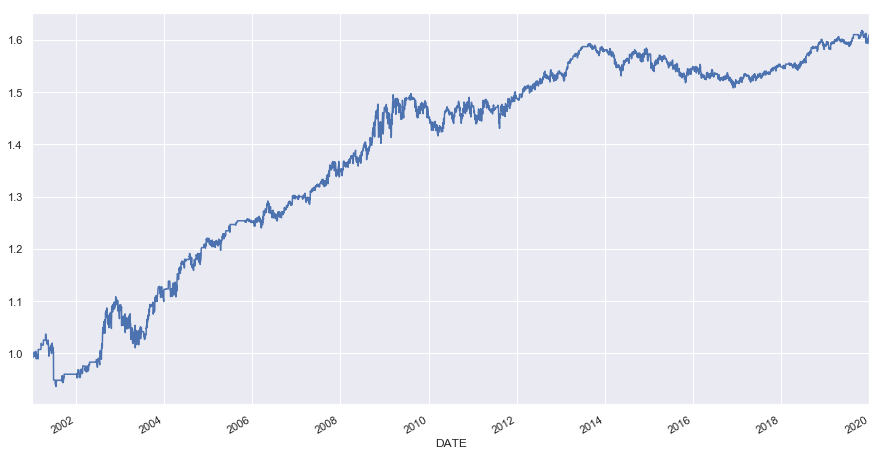

In [297]:
(1+ret).cumprod().plot()

In [70]:
n = [0.5, 1.0 , 1.5, 2.0]
master_lst = {}
master_cum = {}

In [71]:
for number in n: 
    name = '{}std'.format(number)
    ret = backtest(df, selected_pairs, number)
    
    master_lst[name] = ret
    master_cum[name] = (1 + ret).cumprod()

In [72]:
master_df = pd.DataFrame(master_cum)
master_df.to_csv('results_selection_wc.csv')

In [2]:
master_df = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_selection.csv',index_col='DATE', parse_dates=True)

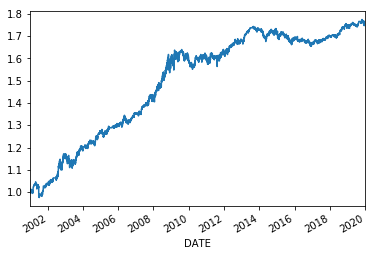

In [111]:
master_df['1.0std'].plot()

In [29]:
perf = master_df['2013':].calc_stats()
perf.set_riskfree_rate(0.019)
perf.display()

Stat                 0.5std      1.0std      1.5std      2.0std
-------------------  ----------  ----------  ----------  ----------
Start                2013-01-03  2013-01-03  2013-01-03  2013-01-03
End                  2019-12-30  2019-12-30  2019-12-30  2019-12-30
Risk-free rate       1.90%       1.90%       1.90%       1.90%

Total Return         5.68%       4.59%       -0.80%      2.70%
Daily Sharpe         -0.41       -0.40       -0.67       -0.51
Daily Sortino        -0.67       -0.66       -1.10       -0.84
CAGR                 0.79%       0.64%       -0.11%      0.38%
Max Drawdown         -3.89%      -5.13%      -6.65%      -3.57%
Calmar Ratio         0.20        0.13        -0.02       0.11

MTD                  -0.76%      -0.17%      -0.14%      0.24%
3m                   -0.17%      -0.40%      0.59%       0.73%
6m                   0.14%       0.59%       0.39%       0.42%
YTD                  1.79%       0.96%       1.02%       0.25%
1Y                   1.79%       0.96

In [24]:
retet = master_df['1.0std'].pct_change() * sqrt(252)

# Create a downside return column with the negative returns only
downside_returns = np.where(retet < 0.00, retet, 0.0)

# Calculate expected return and std dev of downside
expected_return = retet.mean()
down_stdev = downside_returns.std()

In [28]:
down_stdev

0.035497828497053026

In [26]:
(expected_return - 0.019)/down_stdev

-0.4797105721807898

In [67]:
ret = master_df['2.0std']['2015'].pct_change()
ret[0] = 0.0
tstat, pval = stats.ttest_1samp(ret.to_numpy(), 0.0)

In [68]:
print(tstat)
print(pval / 2) 

0.2716257827521324
0.39306697066992535


In [96]:
ret.mean()/ret.std()*sqrt(len(ret))

2.396124769656561

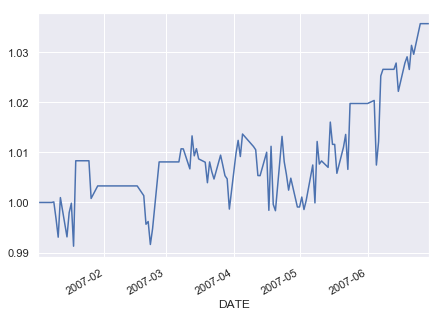

In [43]:
stock1 = 'SCHN'
stock2 = 'SCHP'

start = pd.Timestamp('2006-01')
mid = start + relativedelta(months=+12)
end = start + relativedelta(months=+18)

df_formation = (1 + df[start:mid].pct_change()).cumprod()
df_trading = (1 + df[mid:end].pct_change()).cumprod()

st = df_formation[stock1]
nd = df_formation[stock2]

spread = st - nd
m, u, l = find_entry_exit(spread, 1.0)

signal = create_signal(df_trading, [stock1, stock2], m, u, l)
retet = bt(signal, stock1, stock2)
retet.cum_returns.plot()

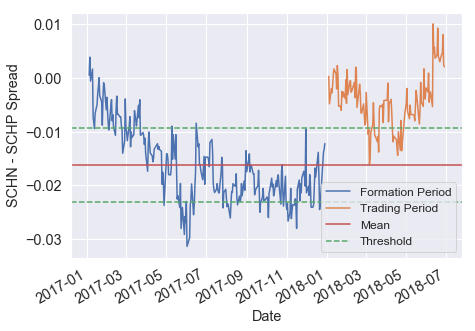

In [42]:
tr_spread = df_trading[stock1] - df_trading[stock2]

sns.set(rc={'figure.figsize':(7,5)})

fig, ax = plt.subplots()
sprd = plt.plot(spread, label='Formation Period')
sprd = plt.plot(tr_spread, label='Trading Period')
sprd = plt.axhline(m, color='r', linestyle='-', label='Mean')
sprd = plt.axhline(u, color='g', linestyle='--', label='Threshold')
sprd = plt.axhline(l, color='g', linestyle='--')
sprd = fig.autofmt_xdate()
sprd = plt.legend(fontsize="medium")
sprd = plt.ylabel("SCHN - SCHP Spread", fontsize="large")
sprd = plt.xlabel("Date", fontsize="large")
sprd = ax.tick_params(labelsize='large')

In [29]:
sprd.figure.savefig("selection_breaking.png")

AttributeError: 'NoneType' object has no attribute 'figure'

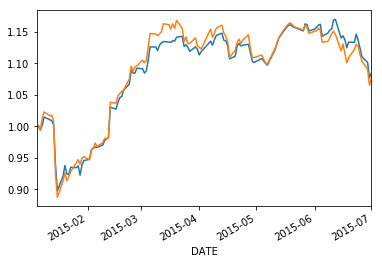

In [258]:
df_formation[stock1].plot()
df_formation[stock2].plot()

In [89]:
spread = (1 + df[stock1].pct_change()).cumprod() - (1 + df[stock2].pct_change()).cumprod()

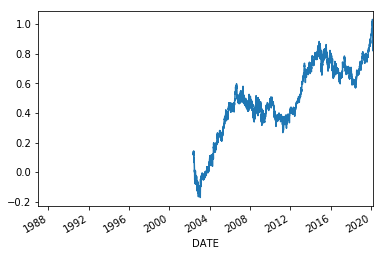

In [90]:
spread.plot()

NameError: name 'm' is not defined

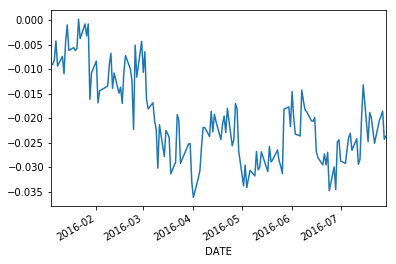

In [93]:
trad_signal = (1 + df[stock1][start:end].pct_change()).cumprod() - (1 + df[stock2][start:end].pct_change()).cumprod()
trad_signal.plot()
plt.axhline(m, color='r', linestyle='-')
plt.axhline(u, color='g', linestyle='--')
plt.axhline(l, color='g', linestyle='--')